In [3]:
import pandas as pd
data = pd.read_csv('./000660.csv')

In [4]:
data_000660 = data[['종가','거래량']]

In [5]:
data_000660.rename(columns={'종가':'Close',
                     '거래량':'Volume'},
            inplace=True)

C:\TempFolder\ipykernel_10312\75747287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_000660.rename(columns={'종가':'Close',


In [14]:
data_000660 = data_000660[:251]

Epoch 1/2000
107/107 [==============================] - 5s 41ms/step


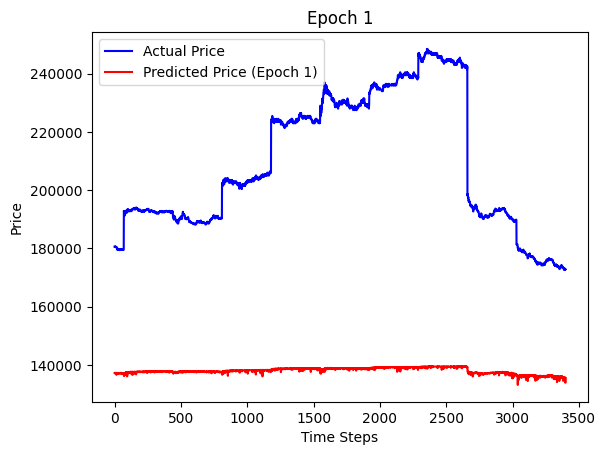

340/340 [==============================] - 45s 122ms/step - loss: 0.1004 - val_loss: 0.0400
Epoch 2/2000
107/107 [==============================] - 4s 42ms/step


<Figure size 640x480 with 0 Axes>

340/340 [==============================] - 41s 121ms/step - loss: 0.0018 - val_loss: 0.0122
Epoch 3/2000
107/107 [==============================] - 5s 42ms/step


<Figure size 640x480 with 0 Axes>

340/340 [==============================] - 41s 122ms/step - loss: 5.2587e-04 - val_loss: 0.0111
Epoch 4/2000
107/107 [==============================] - 5s 42ms/step


<Figure size 640x480 with 0 Axes>

340/340 [==============================] - 42s 123ms/step - loss: 3.4072e-04 - val_loss: 0.0149
Epoch 5/2000
107/107 [==============================] - 5s 43ms/step


<Figure size 640x480 with 0 Axes>

340/340 [==============================] - 42s 124ms/step - loss: 3.4696e-04 - val_loss: 0.0108
Epoch 6/2000
107/107 [==============================] - 5s 43ms/step


<Figure size 640x480 with 0 Axes>

340/340 [==============================] - 42s 123ms/step - loss: 3.1865e-04 - val_loss: 0.0122
Epoch 7/2000
107/107 [==============================] - 4s 42ms/step


<Figure size 640x480 with 0 Axes>

340/340 [==============================] - 42s 122ms/step - loss: 3.2993e-04 - val_loss: 0.0174
Epoch 8/2000
107/107 [==============================] - 5s 43ms/step


<Figure size 640x480 with 0 Axes>

340/340 [==============================] - 41s 122ms/step - loss: 2.9602e-04 - val_loss: 0.0117
Epoch 9/2000
  7/340 [..............................] - ETA: 32s - loss: 1.4522e-04

KeyboardInterrupt: 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras import layers , Model
from sklearn.preprocessing import MinMaxScaler
import os
from matplotlib.animation import FuncAnimation

def download_stock_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date)
    return df[['Close','Volume']].values

# 시계열 데이터 생성 함수
def create_sequences(data, seq_length):
    X, y = [],[]
    for i in range(len(data) - seq_length):
        X.append(data[i:i+ seq_length])
        y.append(data[i + seq_length, 0]) # 종가(Close) 예측
    return np.array(X), np.array(y)

# TimesNet 모델 구현
class TimeSeriesTransform(layers.Layer):
    def __init__(self, d_model, num_harmonics=64):
        super(TimeSeriesTransform, self).__init__()
        self.num_harmonics = num_harmonics
        self.dense = layers.Dense(d_model) # 출력 크기를 d_model로 맞춤

    def call(self, inputs):
        # 주파수 도메인으로 변환
        freq_data = tf.signal.rfft(inputs)
        freq_data = tf.concat([tf.math.real(freq_data), tf.math.imag(freq_data)], axis=-1)
        freq_data = freq_data[:,:,:self.num_harmonics]
        return self.dense(freq_data) # 출력 크키를 d_model로 맞춤

class TimeSeriesBlock(Model):
    def __init__(self, d_model, num_harmonics):
        super(TimeSeriesBlock, self).__init__()
        self.time_transform = TimeSeriesTransform(d_model, num_harmonics)
        self.multihead_attn = layers.MultiHeadAttention(num_heads=8, key_dim=d_model)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            layers.Dense(4 * d_model, activation='relu')
            , layers.Dense(d_model)
            , layers.Dropout(0.1)
        ])
    def call(self, x, training):
        x= self.time_transform(x)
        attn_output = self.multihead_attn(x, x)
        out1 = self.norm1(x + attn_output)
        ffn_output = self.ffn(out1, training=training)
        return self.norm2(out1 + ffn_output)

class TimesNet(Model):
    def __init__(self, input_dim, d_model, num_layers, num_harmonics, output_dim):
        super(TimesNet, self).__init__()
        self.input_proj = layers.Dense(d_model) # 입력 차원 맞추기
        self.blocks = [TimeSeriesBlock(d_model, num_harmonics) for _ in range(num_layers)]
        self.output_proj = layers.Dense(output_dim)

    def call(self, x, training):
        x = self.input_proj(x) # 입력 크기 조정
        for block in self.blocks:
            x = block(x, training)
        return self.output_proj(x[:, -1,:])

# 실시간 시각화 콜백 정의
class RealTimePlot(tf.keras.callbacks.Callback):
    def __init__(self, model, X_test, y_test, scaler, save_dir='plots'):
        super(RealTimePlot, self).__init__()
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.scaler = scaler
        self.save_dir = save_dir
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        self.fig, self.ax = plt.subplots()
        self.predicted = []
        self.actual = scaler.inverse_transform(np.c_[y_test.numpy(), np.zeros_like(y_test.numpy())])[:, 0]
        plt.ion()

    def on_epoch_end(self, epoch, logs=None):
        pred = self.model.predict(self.X_test)
        self.predicted = self.scaler.inverse_transform(np.c_[pred, np.zeros_like(pred)])[:, 0]

        self.ax.clear()
        self.ax.plot(self.actual, label='Actual Price', color='blue')
        self.ax.plot(self.predicted, label=f'Predicted Price (Epoch {epoch+1})', color='red')
        self.ax.set_title(f'Epoch {epoch+1}')
        self.ax.set_xlabel('Time Steps')
        self.ax.set_ylabel('Price')
        self.ax.legend()

        plt.draw()
        plt.pause(0.001)
        save_path = os.path.join(self.save_dir, f'epoch_{epoch+1}.png')
        self.fig.savefig(save_path)
        
    def on_train_end(self, logs=None):
        plt.ioff()
        plt.show()

# 백테스트 함수 정의
def backtest(model, X_test, y_test, scaler, initial_balance=10000):
    balance = initial_balance
    position = 0
    history = []

    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(np.c_[y_pred_scaled, np.zeros_like(y_pred_scaled)])[:, 0]
    y_true = scaler.inverse_transform(np.c_[y_test.numpy(), np.zeros_like(y_test.numpy())])[:, 0] 

    for i in range(len(y_pred) - 1):
        if y_pred[i+1] > y_pred[i]:
            if balance > 0:
                buy_amount = balance / y_true[i]
                position += buy_amount
                balance = 0
                action = 'BUY'
            else:
                action = 'HOLD'
        elif y_pred[i + 1] < y_pred[i]:
            if position > 0:
                balance += position * y_true[i]
                position = 0
                action = 'SELL'
            else:
                action = 'HOLD'
        else:
            action = 'HOLD'

        history.append({
            'Date': i,
            'Action': action,
            'Balance': balance,
            'Position': position,
            'Portfolio Value': balance + position * y_true[i],
            'Predicted Price': y_pred[i],
            'Actual Price': y_true[i]
        })

    final_value = balance + position * y_true[-1]
    history.append({
        'Date': len(y_pred) - 1,
        'Action': 'END',
        'Balance': balance,
        'Position': position,
        'Portfolio Value': final_value,
        'Predicted Price': y_pred[-1],
        'Actual Price': y_true[-1]
        })

    df_history = pd.DataFrame(history)
    return df_history

# 애니메이션 생성 함수
def create_animation(image_dir, output_file, fps=2):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    first_image = plt.imread(os.path.join(image_dir, image_files[0]))
    fig, ax = plt.subplots()
    img = ax.imshow(first_image)

    def update(frame):
        img.set_data(plt.imread(os.path. join(image_dir, image_files[frame])))
        return [img]

    anim = FuncAnimation(fig, update, frames=len(image_files), interval=1000/fps)
    anim.save(output_file, writer='imagemagick', fps=fps)
    plt.show()

# # 데이터 다운로드 및 전처리
ticker = 'AAPL'
start_date = '2021-01-01'
end_date = '2023-01-01'
data = download_stock_data(ticker, start_date, end_date)

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# 시퀀스 데이터 생성
seq_length = 390
X, y = create_sequences(data, seq_length)

# 시간 순서에 따른 데이터 분할
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# # TensorFlow 텐서로 변환
# X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
# X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
# y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
# y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

# # 모델 초기화 및 컴파일
# input_dim= X_train.shape[-1] # 특성 수에 맞춤
# d_model = 64
# num_layers = 3
# num_harmonics = 16
# output_dim = 1

# model = TimesNet(input_dim, d_model, num_layers, num_harmonics, output_dim)
# model.compile(optimizer='adam', loss='mse')

# # 실시간 시각화 콜백 인스턴스 생성
# real_time_plot = RealTimePlot(model, X_test, y_test, scaler, save_dir='plots')

# # 모델 학습
# model.fit(
#     X_train,
#     y_train, 
#     epochs=2000, 
#     batch_size=32, 
#     validation_split=0.2, 
#     callbacks=[real_time_plot]
#     )

# # 백테스트 실행
# backtest_results = backtest(model, X_test, y_test, scaler, initial_balance=10000)

# # 백테스트 결과 출력
# print(backtest_results)

# # 백테스트 결과 시각화
# plt.figure(figsize=(14, 7))
# plt.plot(backtest_results ['Date' ], backtest_results['Portfolio Value'], label='Portfolio Value', color='green')
# plt.plot(backtest_results ['Date' ], backtest_results['Actual Price'], label='Actual Price', color='blue')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.title('Backtest Results - Intraday Trading')
# plt.legend()
# plt.show()

# # 애니메이션 생성
# create_animation(image_dir='plots', output_file='predictions animation.gif', fps=2)

In [13]:
data.values

,Close,Volume
Date,,
2022-01-03,182.009995,104487900
2022-01-04,179.699997,99310400
2022-01-05,174.919998,94537600
2022-01-06,172.000000,96904000
2022-01-07,172.169998,86709100
...,...,...
2022-12-23,131.860001,63814900
2022-12-27,130.029999,69007800
2022-12-28,126.040001,85438400


In [8]:
data_000660.describe()

,Close,Volume
count,17390.000000,17390.000000
mean,131934.669350,12154.698390
std,48871.451716,15628.985772
min,73100.000000,202.000000
25%,87125.000000,3449.000000
50%,119100.000000,7199.500000
75%,177600.000000,14667.000000
max,248500.000000,385039.000000
